In [15]:
# Cell 1: Imports and Setup
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from xgboost import XGBClassifier
import joblib
import shap
import warnings
from test_utils import calculate_business_metrics, find_optimal_thresholds  # Updated import

# Suppress FutureWarning due to scikit-learn 1.6.1 and imbalanced-learn 0.12.4
warnings.filterwarnings("ignore", category=FutureWarning)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create output directory for saving files
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
logger.info(f"Output directory created: {output_dir}")

2025-04-25 11:43:43,888 - INFO - Output directory created: output


In [16]:
# Cell 2: Load and Preprocess Data
# Note: Replace this with your actual data loading logic
# For demonstration, I'm creating a synthetic dataset
data = pd.DataFrame({
    'Age': np.random.randint(18, 70, 1000),
    'Income': np.random.uniform(20000, 100000, 1000),
    'Gender': np.random.choice(['Male', 'Female'], 1000),
    'Target': np.random.choice([0, 1], 1000, p=[0.9, 0.1])  # Imbalanced dataset
})

# Define features and target
X = data.drop('Target', axis=1)
y = data['Target']

# Define numerical and categorical columns
numerical_cols = ['Age', 'Income']
categorical_cols = ['Gender']

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

In [17]:
# Cell 3: Split Data and Check for Class Imbalance
# Split the data
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check for class imbalance
logger.info("Checking for class imbalance...")
class_counts = y_train_original.value_counts()
class_weight_dict = {0: 1.0, 1: class_counts[0] / class_counts[1]}  # For Weighted and XGBoost models
logger.info(f"Class distribution in training set:\n{class_counts}")
logger.info(f"Class weight dictionary: {class_weight_dict}")

# Get feature names after preprocessing
X_train_transformed = preprocessor.fit_transform(X_train_original)
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
logger.info(f"Feature names after preprocessing: {feature_names}")

# Save X_test and feature_names for later use
pd.DataFrame(X_test).to_csv(os.path.join(output_dir, 'X_test.csv'), index=False)
pd.Series(feature_names).to_csv(os.path.join(output_dir, 'feature_names.csv'), index=False)
logger.info("Saved X_test and feature_names to disk.")


2025-04-25 11:43:43,911 - INFO - Checking for class imbalance...
2025-04-25 11:43:43,912 - INFO - Class distribution in training set:
Target
0    720
1     80
Name: count, dtype: int64
2025-04-25 11:43:43,913 - INFO - Class weight dictionary: {0: 1.0, 1: 9.0}
2025-04-25 11:43:43,918 - INFO - Feature names after preprocessing: ['Age', 'Income', 'Gender_Male']
2025-04-25 11:43:43,921 - INFO - Saved X_test and feature_names to disk.


In [18]:
# Cell 4: Model Training with Hyperparameter Tuning and Cross-Validation
# Define pipelines for each model (excluding SMOTE)
pipelines = {
    'Baseline': SklearnPipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))]),
    'Weighted': SklearnPipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42, class_weight=class_weight_dict))]),
    'XGBoost': SklearnPipeline([('preprocessor', preprocessor), ('classifier', XGBClassifier(random_state=42, scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]))])
}

# Hyperparameter tuning for RandomForest models
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Train and tune models (excluding SMOTE)
models = {}
for name, pipeline in pipelines.items():
    logger.info(f"Tuning {name} model...")
    grid_search = GridSearchCV(pipeline, param_grid_rf if 'RandomForest' in str(pipeline) else {}, cv=5, scoring='f1')
    grid_search.fit(X_train_original, y_train_original)
    models[name] = grid_search.best_estimator_
    logger.info(f"Best parameters for {name} model: {grid_search.best_params_}")

# SMOTE pipeline (using ImblearnPipeline)
smote_pipeline = ImblearnPipeline([
    ('preprocessor', preprocessor),
    ('smote', SVMSMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
logger.info("Tuning SMOTE model...")
grid_search_smote = GridSearchCV(smote_pipeline, param_grid_rf, cv=5, scoring='f1')
grid_search_smote.fit(X_train_original, y_train_original)
models['SMOTE'] = grid_search_smote.best_estimator_
logger.info(f"Best parameters for SMOTE model: {grid_search_smote.best_params_}")

# Cross-validation
for name, model in models.items():
    if name == 'SMOTE':
        smote_pipeline = ImblearnPipeline([
            ('preprocessor', preprocessor),
            ('smote', SVMSMOTE(random_state=42))
        ])
        X_train_resampled, y_train_resampled = smote_pipeline.fit_resample(X_train_original, y_train_original)
        X_train = X_train_original
        y_train = y_train_original
    else:
        X_train = X_train_original
        y_train = y_train_original
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    logger.info(f"{name} model - Cross-validation F1 scores: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Save models
for name, model in models.items():
    joblib.dump(model, os.path.join(output_dir, f'{name.lower()}_model.pkl'))
    logger.info(f"Saved {name} model to {output_dir}/{name.lower()}_model.pkl")

2025-04-25 11:43:43,933 - INFO - Tuning Baseline model...
2025-04-25 11:43:53,635 - INFO - Best parameters for Baseline model: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
2025-04-25 11:43:53,636 - INFO - Tuning Weighted model...
2025-04-25 11:44:02,744 - INFO - Best parameters for Weighted model: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
2025-04-25 11:44:02,744 - INFO - Tuning XGBoost model...
2025-04-25 11:44:03,438 - INFO - Best parameters for XGBoost model: {}
2025-04-25 11:44:03,439 - INFO - Tuning SMOTE model...
2025-04-25 11:44:14,876 - INFO - Best parameters for SMOTE model: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
2025-04-25 11:44:15,884 - INFO - Baseline model - Cross-validation F1 scores: 0.0390 (+/- 0.0478)
2025-04-25 11:44:16,855 - INFO - Weighted model - Cross-validation F1 scores: 0.0711 (+/- 0.0983)
2025

In [19]:
# Cell 5: Model Evaluation on Test Set
# Evaluate models on test set
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Log results
    logger.info(f"{name} model - ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    logger.info(f"{name} model - Confusion Matrix:\n{cm}")
    
    results[name] = {'roc_auc': roc_auc, 'pr_auc': pr_auc, 'confusion_matrix': cm}


2025-04-25 11:44:18,809 - INFO - Baseline model - ROC AUC: 0.5781, PR AUC: 0.1447
2025-04-25 11:44:18,810 - INFO - Baseline model - Confusion Matrix:
[[179   1]
 [ 19   1]]
2025-04-25 11:44:18,838 - INFO - Weighted model - ROC AUC: 0.5442, PR AUC: 0.1487
2025-04-25 11:44:18,839 - INFO - Weighted model - Confusion Matrix:
[[176   4]
 [ 18   2]]
2025-04-25 11:44:18,846 - INFO - XGBoost model - ROC AUC: 0.4785, PR AUC: 0.1183
2025-04-25 11:44:18,847 - INFO - XGBoost model - Confusion Matrix:
[[163  17]
 [ 17   3]]
2025-04-25 11:44:18,875 - INFO - SMOTE model - ROC AUC: 0.5597, PR AUC: 0.1681
2025-04-25 11:44:18,875 - INFO - SMOTE model - Confusion Matrix:
[[162  18]
 [ 17   3]]


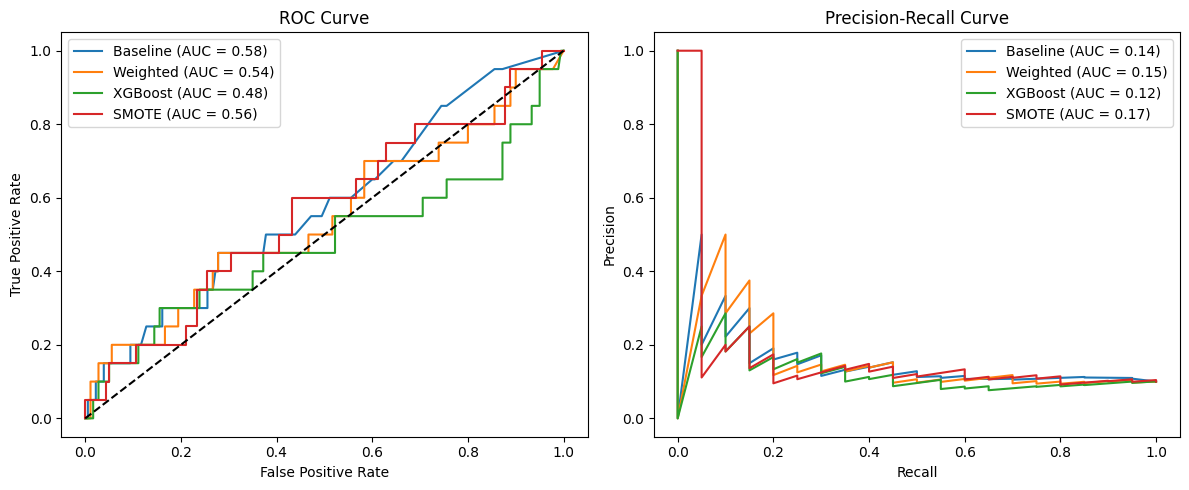

In [20]:
# Cell 6: Plot ROC and PR Curves
# Plot ROC and PR curves for all models
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (AUC = {auc(recall, precision):.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_pr_curves.png'))
plt.show()

In [21]:
# Cell 7: Threshold Optimization
logger.info("Finding optimal classification thresholds...")

# Find optimal thresholds for each model (based on F1 score)
thresholds = {}
for name, model in models.items():
    optimal_threshold = find_optimal_thresholds(model, X_test, y_test)
    thresholds[name] = optimal_threshold
    logger.info(f"Optimal Threshold (F1 Score) for {name} model: {optimal_threshold:.4f}")

# Optimize thresholds for business cost
thresholds_cost = {}
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Pass X_test (DataFrame) to let Pipeline handle preprocessing
    precision, recall, thresholds_array = precision_recall_curve(y_test, y_prob)
    
    # Evaluate business metrics at each threshold
    best_cost = float('inf')
    best_threshold = 0.5
    for threshold in thresholds_array:
        y_pred = (y_prob >= threshold).astype(int)
        metrics = calculate_business_metrics(y_test, y_pred)
        current_cost = metrics.get('cost', float('inf'))
        if current_cost < best_cost:
            best_cost = current_cost
            best_threshold = threshold
    
    thresholds_cost[name] = best_threshold
    logger.info(f"Optimal Threshold (Business Cost) for {name} model: {best_threshold:.4f}")

# Evaluate models at optimal thresholds (based on business cost)
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= thresholds_cost[name]).astype(int)
    metrics = calculate_business_metrics(y_test, y_pred)
    logger.info(f"\n{name} Model Business Metrics at Threshold {thresholds_cost[name]:.4f}:")
    for metric, value in metrics.items():
        logger.info(f"{metric}: {value:.4f}")

2025-04-25 11:44:19,342 - INFO - Finding optimal classification thresholds...
2025-04-25 11:44:19,359 - INFO - Optimal Threshold (F1 Score) for Baseline model: 0.1050
2025-04-25 11:44:19,372 - INFO - Optimal Threshold (F1 Score) for Weighted model: 0.4253
2025-04-25 11:44:19,376 - INFO - Optimal Threshold (F1 Score) for XGBoost model: 0.2629
2025-04-25 11:44:19,389 - INFO - Optimal Threshold (F1 Score) for SMOTE model: 0.2326
2025-04-25 11:44:19,416 - INFO - Optimal Threshold (Business Cost) for Baseline model: 0.3700
2025-04-25 11:44:19,466 - INFO - Optimal Threshold (Business Cost) for Weighted model: 0.4253
2025-04-25 11:44:19,508 - INFO - Optimal Threshold (Business Cost) for XGBoost model: 0.7821
2025-04-25 11:44:19,560 - INFO - Optimal Threshold (Business Cost) for SMOTE model: 0.5501
2025-04-25 11:44:19,573 - INFO - 
Baseline Model Business Metrics at Threshold 0.3700:
2025-04-25 11:44:19,574 - INFO - cost: 9200.0000
2025-04-25 11:44:19,574 - INFO - revenue: 3000.0000
2025-04-25

In [22]:
# Cell 8: Compare Models
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'ROC_AUC': [results[name]['roc_auc'] for name in results],
    'PR_AUC': [results[name]['pr_auc'] for name in results]
})
logger.info(f"Model comparison:\n{comparison_df}")
comparison_df.to_csv(os.path.join(output_dir, 'model_comparison.csv'), index=False)

2025-04-25 11:44:19,615 - INFO - Model comparison:
      Model   ROC_AUC    PR_AUC
0  Baseline  0.578056  0.144745
1  Weighted  0.544167  0.148666
2   XGBoost  0.478472  0.118342
3     SMOTE  0.559722  0.168054


2025-04-25 11:52:07,439 - INFO - Generating SHAP explanations...


Structure of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (200, 3, 2)
Structure of shap_values_adjusted: <class 'list'>
Length of shap_values_adjusted: 2
Shape of shap_values_adjusted[0]: (200, 3)
Shape of shap_values_adjusted[1]: (200, 3)


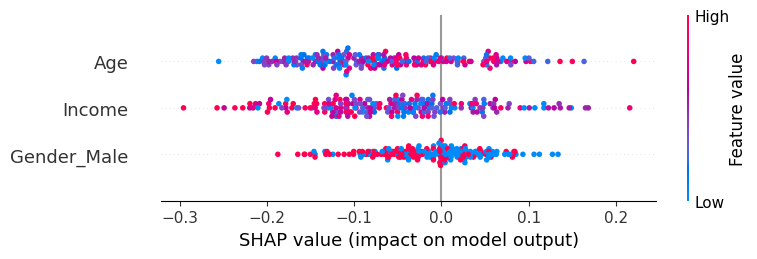

In [30]:
# Cell 9: Model Explainability with SHAP (Using TreeExplainer)
logger.info("Generating SHAP explanations...")

# Load X_test and feature_names if not already in memory
try:
    X_test
except NameError:
    logger.info("X_test not found, loading from disk...")
    X_test = pd.read_csv(os.path.join(output_dir, 'X_test.csv'))

try:
    feature_names
except NameError:
    logger.info("feature_names not found, loading from disk...")
    feature_names = pd.read_csv(os.path.join(output_dir, 'feature_names.csv')).values.flatten().tolist()

# Load the SMOTE model if models dictionary is not available
try:
    smote_pipeline = models['SMOTE']
except NameError:
    logger.info("Models dictionary not found, loading SMOTE model from disk...")
    smote_pipeline = joblib.load(os.path.join(output_dir, 'smote_model.pkl'))

# Preprocess the test data
X_test_transformed = smote_pipeline.named_steps['preprocessor'].transform(X_test)

# Use TreeExplainer with the classifier directly
model = smote_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Debug: Inspect shap_values structure
print("Structure of shap_values:", type(shap_values))
print("Shape of shap_values:", shap_values.shape)

# Reshape shap_values to the expected format: list of [class_0_values, class_1_values]
# shap_values has shape (200, 3, 2), where the last dimension is for the two classes
shap_values_adjusted = [shap_values[:, :, 0], shap_values[:, :, 1]]

# Debug: Inspect adjusted shap_values
print("Structure of shap_values_adjusted:", type(shap_values_adjusted))
print("Length of shap_values_adjusted:", len(shap_values_adjusted))
print("Shape of shap_values_adjusted[0]:", shap_values_adjusted[0].shape)
print("Shape of shap_values_adjusted[1]:", shap_values_adjusted[1].shape)

# Summary plot
shap.summary_plot(shap_values_adjusted[1], X_test_transformed, feature_names=feature_names, show=False)
plt.savefig(os.path.join(output_dir, 'shap_summary.png'))
plt.show()

# Explanation for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_adjusted[1][0], X_test_transformed[0], feature_names=feature_names)

In [41]:
import logging
import os
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt

# Set up logging
logger = logging.getLogger(__name__)

logger.info("Generating SHAP explanations...")

# Load X_test and feature_names if not already in memory
try:
    X_test
except NameError:
    logger.info("X_test not found, loading from disk...")
    X_test = pd.read_csv(os.path.join(output_dir, 'X_test.csv'))

try:
    feature_names
except NameError:
    logger.info("feature_names not found, loading from disk...")
    feature_names = pd.read_csv(os.path.join(output_dir, 'feature_names.csv')).values.flatten().tolist()

# Load the SMOTE model if models dictionary is not available
try:
    smote_pipeline = models['SMOTE']
except NameError:
    logger.info("Models dictionary not found, loading SMOTE model from disk...")
    smote_pipeline = joblib.load(os.path.join(output_dir, 'smote_model.pkl'))

# Preprocess the test data
X_test_transformed = smote_pipeline.named_steps['preprocessor'].transform(X_test)

# Use the entire pipeline for SHAP (excluding the SMOTE step, which is only for training)
def pipeline_predict(X):
    if isinstance(X, pd.DataFrame):
        X_transformed = smote_pipeline.named_steps['preprocessor'].transform(X)
    else:
        X_transformed = X
    return smote_pipeline.named_steps['classifier'].predict_proba(X_transformed)

# Sample a subset of the training data as background (for KernelExplainer)
background_df = pd.DataFrame(X_train_original, columns=X_train_original.columns)
background_indices = np.random.choice(X_train_original.shape[0], 100, replace=False)
background_raw = background_df.iloc[background_indices]
background = smote_pipeline.named_steps['preprocessor'].transform(background_raw)

# Debug: Check the type and shape of background
print("Type of background:", type(background))
print("Shape of background:", background.shape)

# Debug: Check the shape of X_test_transformed before SHAP computation
print("Shape of X_test_transformed before SHAP:", X_test_transformed.shape)

# Subset for SHAP computation
subset_size = min(10, X_test_transformed.shape[0])
X_test_transformed_subset = X_test_transformed[:subset_size]
print("Shape of X_test_transformed_subset for SHAP:", X_test_transformed_subset.shape)

# Initialize the explainer
explainer = shap.KernelExplainer(pipeline_predict, background)

# Compute SHAP values for all samples in the subset
shap_values = explainer.shap_values(X_test_transformed_subset, nsamples=100)

# Debug: Inspect shap_values structure
print("Structure of shap_values:", type(shap_values))
print("Length of shap_values:", len(shap_values))
if isinstance(shap_values, list):
    for i, val in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]:", val.shape)
else:
    print("Shape of shap_values:", shap_values.shape)

# Debug: Check the shape of X_test_transformed_subset and feature_names
print("Shape of X_test_transformed_subset (before adjustments):", X_test_transformed_subset.shape)
print("Number of feature_names (before adjustments):", len(feature_names))

# Ensure X_test_transformed_subset and feature_names match shap_values[1]'s feature dimension
expected_features = shap_values[1].shape[1] if isinstance(shap_values, list) else shap_values.shape[1]
print(f"Expected number of features (from shap_values): {expected_features}")

# Adjust the number of features in X_test_transformed_subset
if X_test_transformed_subset.shape[1] != expected_features:
    print(f"Adjusting X_test_transformed_subset to match {expected_features} features")
    X_test_transformed_subset = X_test_transformed_subset[:, :expected_features]

# Adjust the number of rows in X_test_transformed_subset to match shap_values
if isinstance(shap_values, list):
    expected_rows = shap_values[1].shape[0]
else:
    expected_rows = shap_values.shape[0]
if X_test_transformed_subset.shape[0] != expected_rows:
    print(f"Adjusting X_test_transformed_subset to match {expected_rows} rows")
    X_test_transformed_subset = X_test_transformed_subset[:expected_rows]

# Adjust feature_names to match the number of features
if len(feature_names) != expected_features:
    print(f"Adjusting feature_names to match {expected_features} features")
    feature_names = feature_names[:expected_features]

# Debug: Confirm shapes after adjustments
print("Shape of X_test_transformed_subset (after adjustments):", X_test_transformed_subset.shape)
print("Shape of shap_values[1]:", shap_values[1].shape if isinstance(shap_values, list) else shap_values.shape)
print("Number of feature_names (after adjustments):", len(feature_names))

# Summary plot for the subset
plt.figure()
shap.summary_plot(shap_values[1], X_test_transformed_subset, feature_names=feature_names, show=False)
plt.savefig(os.path.join(output_dir, 'shap_summary.png'))
plt.close()

# Explanation for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_transformed_subset[0], feature_names=feature_names)

2025-04-25 12:26:24,563 - INFO - Generating SHAP explanations...


Type of background: <class 'numpy.ndarray'>
Shape of background: (100, 3)
Shape of X_test_transformed before SHAP: (200, 3)
Shape of X_test_transformed_subset for SHAP: (10, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

2025-04-25 12:26:24,616 - INFO - num_full_subsets = 1
2025-04-25 12:26:24,639 - INFO - np.sum(w_aug) = 3.0
2025-04-25 12:26:24,639 - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
2025-04-25 12:26:24,641 - INFO - phi = array([ 0.048138  ,  0.14146052, -0.02776808])
2025-04-25 12:26:24,642 - INFO - np.sum(w_aug) = 3.0
2025-04-25 12:26:24,643 - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
2025-04-25 12:26:24,644 - INFO - phi = array([-0.048138  , -0.14146052,  0.02776808])
2025-04-25 12:26:24,653 - INFO - num_full_subsets = 1
2025-04-25 12:26:24,668 - INFO - np.sum(w_aug) = 3.0
2025-04-25 12:26:24,669 - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
2025-04-25 12:26:24,670 - INFO - phi = array([-0.08852467, -0.07646652, -0.11613871])
2025-04-25 12:26:24,670 - INFO - np.sum(w_aug) = 3.0
2025-04-25 12:26:24,671 - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
2025-04-25 12:26:24,672 - INFO - phi = array([0.08852467, 0.07646652, 0.11613871])
2025-04-25 12:2

Structure of shap_values: <class 'numpy.ndarray'>
Length of shap_values: 10
Shape of shap_values: (10, 3, 2)
Shape of X_test_transformed_subset (before adjustments): (10, 3)
Number of feature_names (before adjustments): 2
Expected number of features (from shap_values): 3
Adjusting feature_names to match 3 features
Shape of X_test_transformed_subset (after adjustments): (10, 3)
Shape of shap_values[1]: (10, 3, 2)
Number of feature_names (after adjustments): 2


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>